In [1]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import time

# Датасет  

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

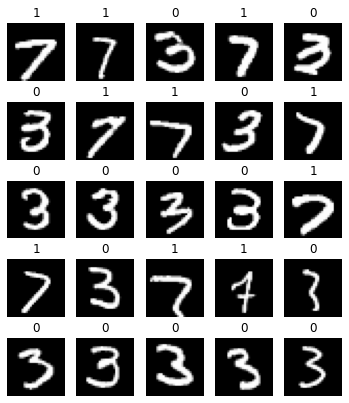

In [15]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [16]:
X, y = next(iter(train_loader))
X = X.view(X.shape[0], -1)
X.shape

torch.Size([128, 784])

In [17]:
w = torch.rand(784, 1)
pred = X.matmul(w)
pred.shape

torch.Size([128, 1])

In [18]:
y = np.expand_dims(y, 1)

# Многослойный перцептрон

In [19]:
learning_rate = 0.01 
epochs = 5  

batch_size = 128 
n_feat = 784
inner_feat = 300

w1 = np.random.rand(n_feat, inner_feat) * 0.01
b1 = np.zeros(inner_feat)
w2 = np.random.rand(inner_feat, 1) * 0.01
b2 = np.zeros(1)

losses = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
        
        h1 = x.dot(w1) + b1
        z1 = 1 / (1 + np.exp(-h1))
        h2 = z1.dot(w2) + b2
        z2 = 1 / (1 + np.exp(-h2))
        
        bce = (-np.sum(np.multiply(np.log(z2), y) + np.multiply((1 - y), np.log(1 - z2)))) / batch_size
        losses.append(bce)
        
        dz2 = ((1 - y) / (1 - z2) - y / z2) * (z2 * (1 - z2)) 
        da = dz2 / batch_size

        dw2 = np.dot(z1.T, da)
        db2 = np.sum(da)
        
        dz1 = z1 * np.dot(dz2, w2.T)

        dw1 = np.dot(x.T, dz1)
        db1 = np.sum(dz1.T)

        w2 -= learning_rate * dw2
        b2 -= learning_rate * db2
        w1 -= learning_rate * dw1
        b1 -= learning_rate * db1

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


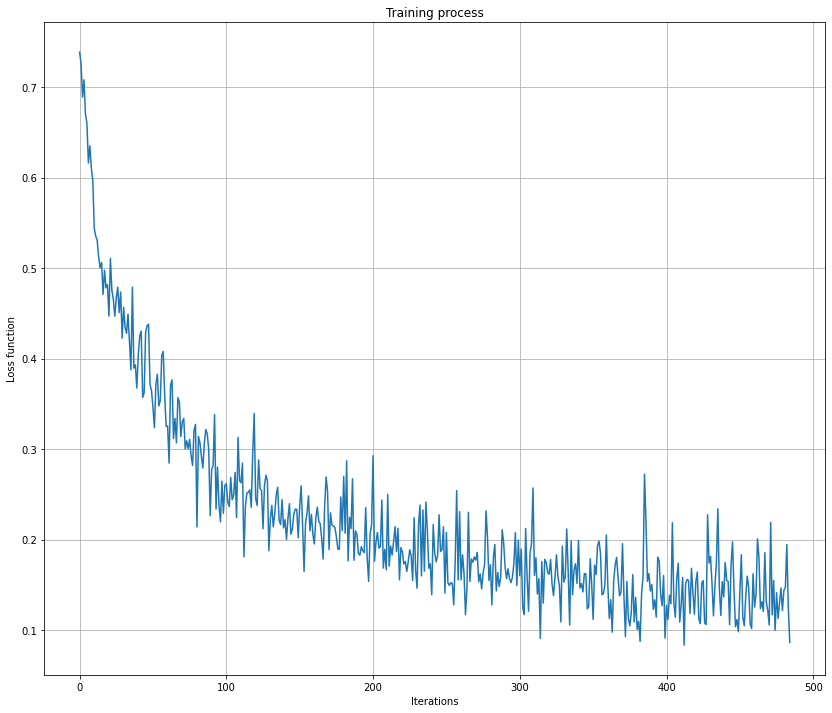

In [20]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Тестирование

In [21]:
losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:

    x = x.view(x.shape[0], -1).numpy()
    y = np.expand_dims(y.numpy(), 1)

    h1 = x.dot(w1) + b1
    z1 = 1 / (1 + np.exp(-h1))
    h2 = z1.dot(w2) + b2
    z2 = 1 / (1 + np.exp(-h2))

    bce = (-np.sum(np.multiply(np.log(z2), y) + np.multiply((1 - y), np.log(1 - z2)))) / batch_size
    losses.append(bce)

    losses_test.append(bce)
    predicted.extend(z2)
    true_lbls.extend(y) 

In [22]:
print(len(predicted), len(true_lbls))

2038 2038


In [23]:
pred = np.array([round(i[0]) for i in predicted]) 
t_lbls = np.array(true_lbls).squeeze()
f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

F1 score is equal to: 0.95
